<a href="https://colab.research.google.com/github/Bishal-Nengminja/Stacked-LSTM-for-Stock-Market-Prediction/blob/main/Stacked_LSTM_Stock_Market_Prediction_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Imports and Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import pandas_datareader as pdr

import plotly.graph_objects as go
import joblib  # For saving scalers

sns.set(style='whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings('ignore')

**2. Load Data and Basic Exploration**

In [2]:
df = pd.read_csv('AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [3]:
pd.to_datetime(df['date']).dt.date

,date
0,2015-05-27
1,2015-05-28
2,2015-05-29
3,2015-06-01
4,2015-06-02
...,...
1253,2020-05-18
1254,2020-05-19
1255,2020-05-20
1256,2020-05-21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1258 non-null   int64  
 1   symbol       1258 non-null   object 
 2   date         1258 non-null   object 
 3   close        1258 non-null   float64
 4   high         1258 non-null   float64
 5   low          1258 non-null   float64
 6   open         1258 non-null   float64
 7   volume       1258 non-null   int64  
 8   adjClose     1258 non-null   float64
 9   adjHigh      1258 non-null   float64
 10  adjLow       1258 non-null   float64
 11  adjOpen      1258 non-null   float64
 12  adjVolume    1258 non-null   int64  
 13  divCash      1258 non-null   float64
 14  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 147.6+ KB


In [5]:
df.describe()

,Unnamed: 0,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.0
mean,628.500000,167.723998,169.230475,166.039780,167.548266,3.500397e+07,162.666715,164.131054,161.028013,162.493082,3.500397e+07,0.010477,1.0
std,363.297628,56.850796,57.500128,56.006773,56.612707,1.729100e+07,58.733820,59.402842,57.869246,58.494560,1.729100e+07,0.083366,0.0
min,0.000000,90.340000,91.670000,89.470000,90.000000,1.136204e+07,84.954351,86.205062,84.136216,84.634620,1.136204e+07,0.000000,1.0
25%,314.250000,116.327500,117.405000,115.602500,116.482500,2.359205e+07,109.484490,110.393556,107.962457,109.135002,2.359205e+07,0.000000,1.0
50%,628.500000,160.485000,162.080000,158.974250,160.345000,3.064771e+07,154.710645,156.091874,153.054341,154.410017,3.064771e+07,0.000000,1.0
75%,942.750000,199.785000,201.277500,198.170000,199.520000,4.100487e+07,196.960053,198.428438,195.281553,196.452903,4.100487e+07,0.000000,1.0
max,1257.000000,327.200000,327.850000,323.350000,324.730000,1.622063e+08,326.337147,326.357095,322.497300,323.873661,1.622063e+08,0.820000,1.0


In [6]:
df.isnull().sum()

,0
Unnamed: 0,0
symbol,0
date,0
close,0
high,0
low,0
open,0
volume,0
adjClose,0
adjHigh,0


**3. Visualization and Moving Averages**

In [7]:
# Calculate moving averages
df['MA20'] = df['close'].rolling(window=20).mean()
df['MA50'] = df['close'].rolling(window=50).mean()

# Plot using Plotly interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['close'], mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x=df['date'], y=df['MA20'], mode='lines', name='20-day MA'))
fig.add_trace(go.Scatter(x=df['date'], y=df['MA50'], mode='lines', name='50-day MA'))
fig.update_layout(title='Apple Stock Price with Moving Averages', xaxis_title='Date', yaxis_title='Price (USD)')
fig.show()

**4. Data Preprocessing (Scaling and Sequence Creation)**

In [8]:
# Use only 'close' column and scale it
close_prices = df['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(close_prices)

In [9]:
# Save the scaler for later use (in deployment)
joblib.dump(scaler, 'scaler.save')

['scaler.save']

In [10]:
# Create sequences for LSTM (seq length = 60)
seq_length = 60
X = []
y = []

for i in range(seq_length, len(close_scaled)):
    X.append(close_scaled[i-seq_length:i, 0])
    y.append(close_scaled[i, 0])

In [11]:
X, y = np.array(X), np.array(y)

In [12]:
# Reshape X for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

**5. Train/Test Split**

In [13]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [14]:
X_train.shape

(958, 60, 1)

In [15]:
X_test.shape

(240, 60, 1)

**6. Build Stacked LSTM Model**

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length,1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

**7. Train the Model with Early Stopping**

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - loss: 0.0269 - val_loss: 0.0042
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/

**8. Evaluate Model and Plot Predictions**

In [18]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


array([[0.37568855],
       [0.38450631],
       [0.39444306],
       [0.40461832],
       [0.41448325],
       [0.42408568],
       [0.43318647],
       [0.44171125],
       [0.44942415],
       [0.4561225 ],
       [0.46135673],
       [0.4654627 ],
       [0.46861866],
       [0.4707556 ],
       [0.47232607],
       [0.473682  ],
       [0.47515437],
       [0.47680703],
       [0.478131  ],
       [0.47903973],
       [0.47972468],
       [0.48010492],
       [0.4803433 ],
       [0.48072335],
       [0.4812532 ],
       [0.48177403],
       [0.4824526 ],
       [0.48297054],
       [0.48370814],
       [0.48494607],
       [0.4866899 ],
       [0.48864606],
       [0.49068728],
       [0.49289474],
       [0.49511945],
       [0.49770933],
       [0.5001779 ],
       [0.50178784],
       [0.50110567],
       [0.49824592],
       [0.49382135],
       [0.4889116 ],
       [0.48391595],
       [0.4791113 ],
       [0.47564518],
       [0.47323212],
       [0.47157693],
       [0.470

In [19]:
# Inverse scale predictions and true values
scaler = joblib.load('scaler.save')
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
print(y_pred_rescaled)
print(y_test_rescaled)

[[179.32559]
 [181.41417]
 [183.76779]
 [186.17789]
 [188.5145 ]
 [190.78893]
 [192.94455]
 [194.96373]
 [196.7906 ]
 [198.37718]
 [199.61696]
 [200.58951]
 [201.33702]
 [201.84317]
 [202.21516]
 [202.53632]
 [202.88507]
 [203.27652]
 [203.5901 ]
 [203.80534]
 [203.96759]
 [204.05765]
 [204.11412]
 [204.20413]
 [204.32964]
 [204.45299]
 [204.61372]
 [204.7364 ]
 [204.9111 ]
 [205.20433]
 [205.61737]
 [206.0807 ]
 [206.5642 ]
 [207.08705]
 [207.61398]
 [208.22743]
 [208.81213]
 [209.19347]
 [209.03189]
 [208.35454]
 [207.30653]
 [206.1436 ]
 [204.96034]
 [203.8223 ]
 [203.00131]
 [202.42976]
 [202.0377 ]
 [201.90027]
 [202.11621]
 [202.67627]
 [203.57718]
 [204.74313]
 [205.81746]
 [206.73196]
 [207.38776]
 [207.79814]
 [208.08278]
 [208.29778]
 [208.39542]
 [208.46202]
 [208.64297]
 [208.98076]
 [209.49004]
 [210.20676]
 [211.28099]
 [212.68645]
 [214.2163 ]
 [215.7541 ]
 [217.22394]
 [218.61641]
 [219.85077]
 [220.79588]
 [221.43556]
 [221.75656]
 [221.87778]
 [221.84113]
 [221.6599 ]

- Calculate metrics

In [20]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"MAE: {mae:.4f}")

MAE: 10.2619


In [21]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse:.4f}")

RMSE: 12.8800


In [22]:
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled)/y_test_rescaled)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 3.81%


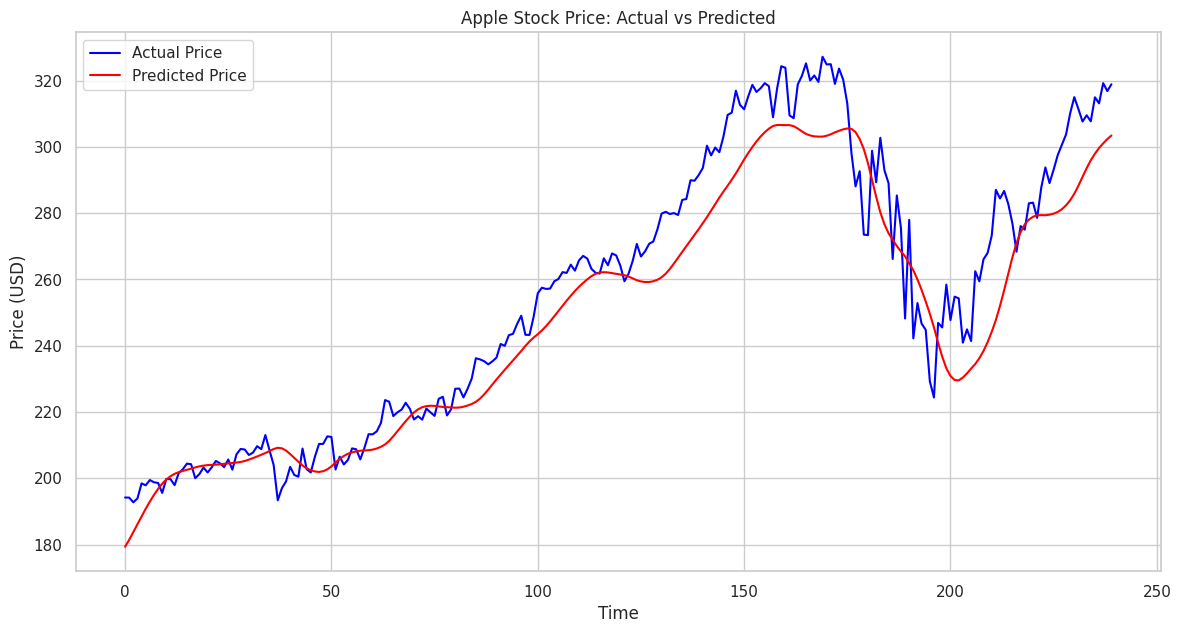

In [23]:
# Plot actual vs predicted prices
plt.figure(figsize=(14,7))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Price', color='red')
plt.title('Apple Stock Price: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

**9. Save Model**

In [26]:
model.save('stacked_lstm_model.keras')
print("Model saved as 'stacked_lstm_model.keras'")

Model saved as 'stacked_lstm_model.keras'


 **10. Predict Future Prices Using Last 60 Days**

In [25]:
# Use last 60 days from dataset
last_60_days = close_prices[-seq_length:]
last_60_scaled = scaler.transform(last_60_days)

# Predict next 5 days step-by-step
input_seq = last_60_scaled.flatten().tolist()
predictions_scaled = []

for _ in range(5):  # next 5 days
    X_input = np.array(input_seq[-seq_length:]).reshape(1, seq_length, 1)
    pred_scaled = model.predict(X_input)[0,0]
    predictions_scaled.append(pred_scaled)
    input_seq.append(pred_scaled)

# Inverse transform predictions
predictions_scaled = np.array(predictions_scaled).reshape(-1,1)
predictions = scaler.inverse_transform(predictions_scaled).flatten()

print("Next 5 predicted closing prices:")
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Next 5 predicted closing prices:
[304.39963 304.8006  304.5548  303.69644 302.3183 ]


In [27]:
from google.colab import files
files.download('stacked_lstm_model.keras')
files.download('scaler.save')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>